# Model 

## Import of data and libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time 
from tqdm import tqdm
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score, auc, f1_score

In [2]:
# Graph 2 Vec features 
df = pd.read_csv("../data/graph2vec_features.csv", index_col="Unnamed: 0")
print(df.shape)
df.head()

(7463, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.065628,0.049704,-0.021823,-0.016675,-0.005449,0.019042,0.029697,0.054031,0.028745,-0.018336,...,-0.020870,-0.005423,0.006858,-0.019536,0.010546,-0.006566,0.000269,-0.033477,0.031000,-0.015704
1,0.081471,0.059426,-0.019663,-0.024317,-0.009260,0.020637,0.031575,0.064183,0.032366,-0.018726,...,-0.020377,-0.004619,0.012629,-0.021779,0.015394,-0.004374,-0.001674,-0.038373,0.035886,-0.016360
2,0.083969,0.062961,-0.024718,-0.020484,-0.011173,0.019067,0.032914,0.063150,0.030090,-0.018712,...,-0.023713,-0.009308,0.013349,-0.018821,0.010404,-0.005074,0.002161,-0.037117,0.032850,-0.020914
3,0.079689,0.055927,-0.025618,-0.019749,-0.010904,0.017525,0.039774,0.065543,0.033321,-0.018304,...,-0.017079,-0.006069,0.008769,-0.022917,0.011966,-0.007799,0.002684,-0.033715,0.034583,-0.017478
4,0.056590,0.037910,-0.015739,-0.014299,-0.005001,0.017197,0.027510,0.043394,0.024416,-0.014998,...,-0.010161,-0.008684,0.007738,-0.013768,0.010249,-0.009081,-0.000166,-0.028182,0.024253,-0.009483


In [3]:
# Mol 2 Vec
df_mol = pd.read_csv("../data/mol2vec_features.csv", index_col="Unnamed: 0")
print(df_mol.shape)
#df_mol["target"] = df.target
df_mol.head()

(7463, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.432892,-1.148265,-1.295593,2.830640,1.501820,0.395403,-2.729602,-1.660501,1.254106,-1.217803,...,-0.100305,1.867382,3.234128,-1.098881,-2.462197,-1.142829,-2.302124,-0.135109,-2.861818,-0.552655
1,-0.695608,0.665684,-0.570668,-0.499616,3.588313,-0.173725,-2.371433,-0.942077,3.326228,-1.887655,...,-0.149212,1.695873,3.216152,0.603311,-1.743970,-0.981935,-1.515858,-1.247859,-4.260800,-1.085652
2,5.843926,-7.150183,-5.401794,5.323905,-0.346161,-1.742886,-7.615536,-1.616421,-1.934688,1.058362,...,-4.199099,8.673381,5.756387,-1.673199,-6.537354,-7.571887,-5.923907,-4.011438,-11.431290,0.976179
3,0.234648,0.251645,-3.052813,-1.383571,3.002864,-0.269477,-3.548233,0.150195,1.836320,2.348825,...,0.671994,4.270945,1.536611,2.394891,0.838491,-0.534440,0.500261,-1.763674,-4.088911,0.781893
4,0.239408,-1.481567,-0.711803,3.640964,-1.091899,1.142029,-2.324828,0.227074,3.509125,2.812115,...,-2.277948,3.842560,4.980514,-0.003749,-1.949442,-0.427221,-1.615954,0.038887,-2.373425,-1.228086


In [4]:
df_i = pd.read_csv('../data/molecule_training.csv')
relevant_columns = ['Maximum Degree', 'Minimum Degree', 'Molecular Weight',
       'Number of H-Bond Donors', 'Number of Rings',
       'Number of Rotatable Bonds', 'Polar Surface Area', 'target']
df_i = df_i[relevant_columns] # Keep only relevant features 
df_i = df_i.drop(1629) # Drop a row where we could not get features
df_i = df_i.reset_index()
df_i.drop(columns=["index"], inplace=True)
print(df_i.shape)
df_i.tail()

(7463, 8)


,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,target
7458,3.0,1.0,195.476,0.0,1.0,1.0,0.00,0
7459,4.0,1.0,282.365,0.0,2.0,2.0,66.01,0
7460,3.0,1.0,194.259,1.0,2.0,2.0,48.14,0
7461,3.0,1.0,173.393,1.0,0.0,1.0,37.30,0
7462,3.0,0.0,266.092,5.0,1.0,1.0,156.79,0


In [5]:
## Concatenate all datasets
df_all = pd.concat([df, df_mol, df_i], axis=1)
print(df_all.shape)
df_all.tail()

(7463, 436)


,0,1,2,3,4,5,6,7,8,9,...,298,299,Maximum Degree,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,target
7458,0.071388,0.057282,-0.018582,-0.024575,-0.005261,0.017138,0.031621,0.062663,0.025884,-0.023945,...,-3.383513,-1.740533,3.0,1.0,195.476,0.0,1.0,1.0,0.00,0
7459,0.079441,0.059796,-0.024358,-0.021384,-0.005186,0.021258,0.035781,0.065075,0.033338,-0.021614,...,-8.346727,-1.144652,4.0,1.0,282.365,0.0,2.0,2.0,66.01,0
7460,0.076676,0.057820,-0.020273,-0.025702,-0.007925,0.021412,0.034846,0.062649,0.026392,-0.019209,...,-6.110288,-1.440576,3.0,1.0,194.259,1.0,2.0,2.0,48.14,0
7461,0.082528,0.056958,-0.026536,-0.025169,-0.007524,0.026013,0.037184,0.066294,0.035405,-0.021826,...,-1.586442,-0.852786,3.0,1.0,173.393,1.0,0.0,1.0,37.30,0
7462,0.084302,0.062029,-0.024049,-0.025748,-0.010429,0.023978,0.040226,0.062843,0.030984,-0.025414,...,-9.540288,0.146884,3.0,0.0,266.092,5.0,1.0,1.0,156.79,0


### Useful functions

In [6]:
def plot_variance_explained_curve_PCA(df, n_max, threshold, job_done, Explained_variances=[]):
    
    if not job_done:
        # Scale the features using min-max scaling
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(df)
        
        Explained_variances = []
        for k in tqdm(range(n_max)):
            # Create a PCA object with the desired number of components 
            pca = PCA(n_components=k)

            # Fit the PCA object to the scaled data and transform the data to the reduced feature space
            X_reduced = pca.fit_transform(X_scaled)

            # Get the explained variance ratio for each principal component
            explained_variances = pca.explained_variance_ratio_
            Explained_variances.append(sum(explained_variances))

    # Plot the curve
    plt.plot(Explained_variances, label="Explained variance")
    plt.plot([threshold for k in range(n_max)], marker="_", label="threshold")
    plt.xlabel("number of components")
    plt.ylabel("Explained variance")
    plt.title("Explained variance wrt number of components used in the PCA")
    plt.legend()
    plt.show()
    
    return Explained_variances


def plot_t_SNE_graph(df):
    
    # Separate features and labels
    X = df.drop('target', axis=1)
    y = df['target']

    # Initialize t-SNE object
    tsne = TSNE(n_components=2, random_state=0)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X)

    # Create the plot
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
    plt.title('t-SNE Plot')
    plt.show()

## Data visualization

### Graph2Vec

100%|█████████████████████████████████████████| 128/128 [00:12<00:00, 10.27it/s]


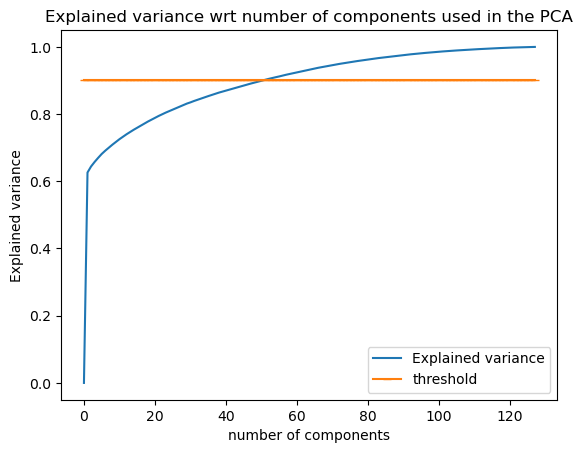

In [7]:
Explained_variances = plot_variance_explained_curve_PCA(df.drop('target', axis=1), 128, 0.9, False)

Let's try to see what's the t-SNE plot of our Graph to Vec embedding 

/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


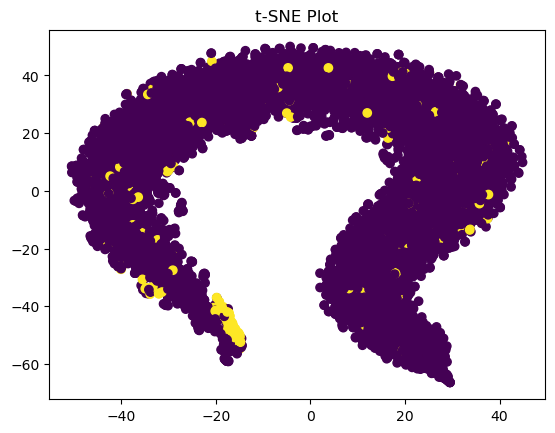

In [6]:
plot_t_SNE_graph(df)

We can that the 2 classes (toxic and non toxic) are not properly separable, which might mean that this embedding is not necessarily the appropriate one for our dataset. Let's try to see how bad/good a baseline model will perform, and then try to improve performance wth more complex models.

### Mol2Vec

For this embedding, we have 300 features. We can begin with runing a PCA, in order to reduce the dimension of the features.

100%|█████████████████████████████████████████| 300/300 [01:11<00:00,  4.20it/s]


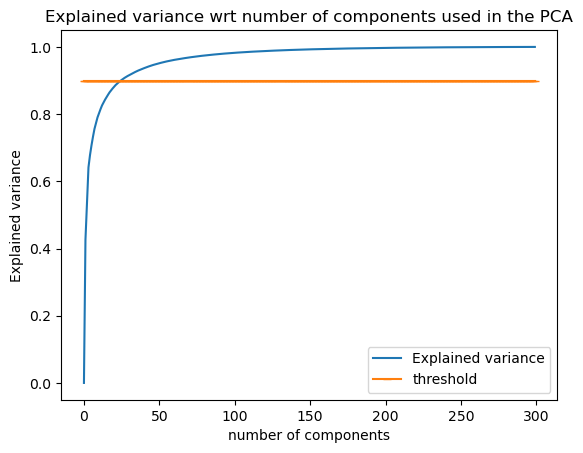

In [10]:
Explained_variances_mol = plot_variance_explained_curve_PCA(df_mol, 300, 0.9, False)

In [10]:
optimal_n_components = 30

# Scale the features using min-max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_mol)

# Create a PCA object with the desired number of components 
pca = PCA(n_components=optimal_n_components)

# Fit the PCA object to the scaled data and transform the data to the reduced feature space
X_reduced = pca.fit_transform(X_scaled)


# Get the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_


# Create a new dataframe with the reduced feature space
data_reduced = pd.DataFrame(X_reduced)
#data_reduced["target"] = df.target

In [25]:
# Get the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_

# Print the cumulative explained variance
print(f'Cumulative explained variance: {sum(explained_variances)}')

Cumulative explained variance: 0.9160536776859065


/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


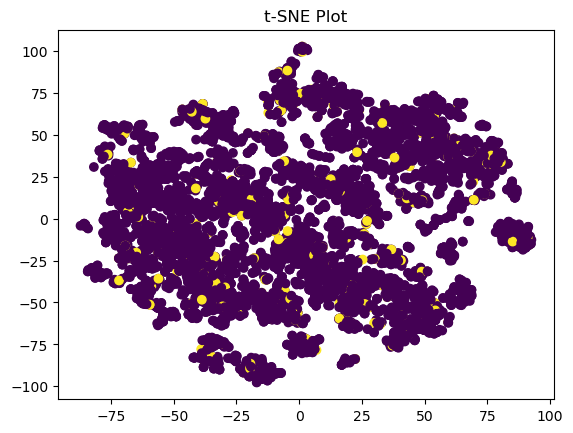

In [14]:
# Add the target feature
data_reduced["target"] = df.target 

plot_t_SNE_graph(data_reduced)

### Graph2Vec + Mol2Vec

In [10]:
## Concatenate Graph2Vec and Mol2Vec
df_conc = pd.concat([df_mol, df], axis=1)
df_conc.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.432892,-1.148265,-1.295593,2.830640,1.501820,0.395403,-2.729602,-1.660501,1.254106,-1.217803,...,-0.020870,-0.005423,0.006858,-0.019536,0.010546,-0.006566,0.000269,-0.033477,0.031000,-0.015704
1,-0.695608,0.665684,-0.570668,-0.499616,3.588313,-0.173725,-2.371433,-0.942077,3.326228,-1.887655,...,-0.020377,-0.004619,0.012629,-0.021779,0.015394,-0.004374,-0.001674,-0.038373,0.035886,-0.016360
2,5.843926,-7.150183,-5.401794,5.323905,-0.346161,-1.742886,-7.615536,-1.616421,-1.934688,1.058362,...,-0.023713,-0.009308,0.013349,-0.018821,0.010404,-0.005074,0.002161,-0.037117,0.032850,-0.020914
3,0.234648,0.251645,-3.052813,-1.383571,3.002864,-0.269477,-3.548233,0.150195,1.836320,2.348825,...,-0.017079,-0.006069,0.008769,-0.022917,0.011966,-0.007799,0.002684,-0.033715,0.034583,-0.017478
4,0.239408,-1.481567,-0.711803,3.640964,-1.091899,1.142029,-2.324828,0.227074,3.509125,2.812115,...,-0.010161,-0.008684,0.007738,-0.013768,0.010249,-0.009081,-0.000166,-0.028182,0.024253,-0.009483


100%|█████████████████████████████████████████| 400/400 [03:10<00:00,  2.10it/s]


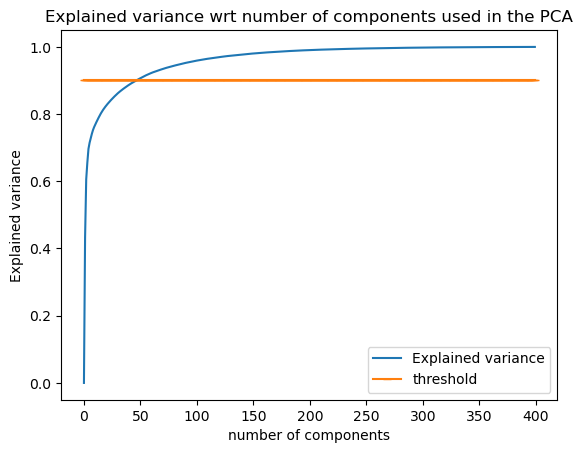

In [11]:
Explained_variances_conc = plot_variance_explained_curve_PCA(df_conc, 400, 0.9, False)

### Concatenated dataframes 

Here, we concatenate all the three dataframes, to have both molecule 2 vec features, graph2Vec features, and also the original features that we had in the original dataframe. 

100%|█████████████████████████████████████████| 400/400 [02:54<00:00,  2.29it/s]


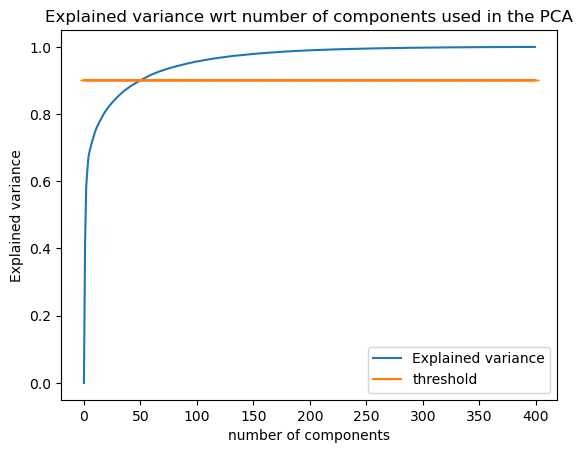

In [36]:
Explained_variances_all = plot_variance_explained_curve_PCA(df_all, 400, 0.9, False)

/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


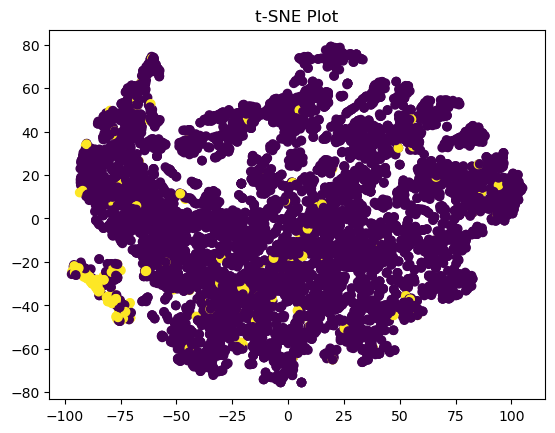

In [42]:
plot_t_SNE_graph(df_all)

In [11]:
optimal_n_components = 50

# Scale the features using min-max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_all.drop(columns=["target"]))

# Create a PCA object with the desired number of components 
pca = PCA(n_components=optimal_n_components)

# Fit the PCA object to the scaled data and transform the data to the reduced feature space
X_reduced = pca.fit_transform(X_scaled)


# Get the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_


# Create a new dataframe with the reduced feature space
data_reduced_all = pd.DataFrame(X_reduced)
#data_reduced["target"] = df.target

In [11]:
# Get the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_

# Print the cumulative explained variance
print(f'Cumulative explained variance: {sum(explained_variances)}')

Cumulative explained variance: 0.905739835824752


In [60]:
data_reduced_all["target"] = df_all["target"]

/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


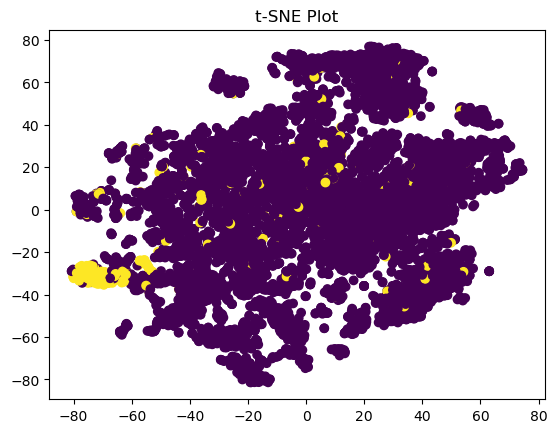

In [61]:
plot_t_SNE_graph(data_reduced_all)

## Feature importance

In [43]:
X_train, X_val, y_train, y_val = train_test_split(df_all.drop('target', axis=1), df_all[['target']], test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=1500, random_state=42)
rf.fit(X_train, y_train)

# Compute feature importances
importances = rf.feature_importances_

sorted_idx = importances.argsort()

/var/folders/v2/_1kj2jc57736h6nlnncs10080000gn/T/ipykernel_18498/2585256922.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Text(0.5, 0, 'Random Forest Feature Importance')

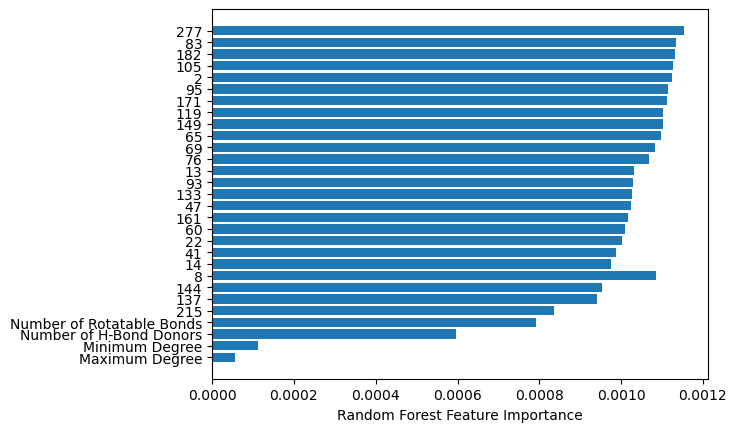

In [44]:
plt.barh(df_all.columns[sorted_idx][:30], importances[sorted_idx][:30])
plt.xlabel("Random Forest Feature Importance")

Here, what we notice is that even the most important features (column 109), its importance coefficient is very low (importance coefficient is between 0 and 1). This means that either features are not adapted to this model, or the Random Forest model is not adapted to this taks ...

# Train & Test & Validation sets

## Datasets with Graph features (Graph2Vec)

In [7]:
X_G, X_test_G, y_G, y_test_G = train_test_split(df, df_all['target'], test_size=0.2, random_state=42, stratify=df_all['target'])

print(f"Size of the test set: {len(y_test_G)}")

X_train_G, X_val_G, y_train_G, y_val_G = train_test_split(X_G, y_G, test_size=0.2, random_state=42, stratify=y_G)

print(f"Size of the train set: {len(y_train_G)}")

Size of the test set: 1493
Size of the train set: 4776


## Datasets with Mol features (Mol2Vec)

In [12]:
data_reduced["target"] = df_all["target"]

In [13]:
X_m, X_test_m, y_m, y_test_m = train_test_split(data_reduced.drop('target', axis=1), data_reduced["target"], test_size=0.2, random_state=42, stratify=data_reduced["target"])

print(f"Size of the test set: {len(y_test_m)}")

X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42, stratify=y_m)

print(f"Size of the train set: {len(y_train_m)}")


Size of the test set: 1493
Size of the train set: 4776


## Concatenated datasets with PCA

In [14]:
data_reduced_all['target'] = df_all['target']

In [15]:
X_all, X_test_all, y_all, y_test_all = train_test_split(data_reduced_all.drop('target', axis=1), data_reduced_all["target"], test_size=0.2, random_state=42, stratify=data_reduced_all["target"])

print(f"Size of the test set: {len(y_test_all)}")

X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

print(f"Size of the train set: {len(y_train_all)}")

Size of the test set: 1493
Size of the train set: 4776


## Baseline model: Naive bayesian 

For this baseline model, we will implement an easy to go model, that is quite fast to run : Naive bayesian model !

But first, let's split ou dataset into train and test sets : 

### Graph2Vec

In [16]:
%%time 

baseline_model = GaussianNB()

baseline_model.fit(X_train_G, y_train_G)

CPU times: user 11.6 ms, sys: 5.18 ms, total: 16.8 ms
Wall time: 16.4 ms


GaussianNB()

In [17]:
y_pred = baseline_model.predict(X_val_G)

In [18]:
print(f"The accuracy on the validation set is {round(accuracy_score(y_val_G, y_pred),4)}")

The accuracy on the validation set is 0.7973


In [19]:
print(f"The f1-score on the validation set is {round(f1_score(y_val_G, y_pred),4)}")

The f1-score on the validation set is 0.2039


In [20]:
print(f"The AUC score on the validation set is {round(roc_auc_score(y_val_G, y_pred),4)}")

The AUC score on the validation set is 0.7185


Here, we can notice the importance of the metric used to assess the performance of our model. Indeed, if we rely only on the accuracy and ROC AUC score, one can think that the model is not that bad. However, these two metrics are not adapted to unbalanced datasets, as it's the case for our datset. Conversely, the f-score metric is well suited for unbalanced datset, and reveal that the model is actually poorly performing. 

We will then focus on this metric for what follows !

### Mol2Vec

In [21]:
%%time 

baseline_model = GaussianNB()

baseline_model.fit(X_train_m, y_train_m)

CPU times: user 5.28 ms, sys: 1.68 ms, total: 6.96 ms
Wall time: 5.41 ms


GaussianNB()

In [22]:
y_pred_m = baseline_model.predict(X_val_m)

In [23]:
print(f"The f1-score on the validation set is {round(f1_score(y_val_m, y_pred_m),4)}")

The f1-score on the validation set is 0.4912


With this embedding and PCA dimension reduction, the f1-score is a bit worser.

NB : Withotu PCA, we get an even worser score.

### Concatenated dataframes 

In [24]:
%%time 

baseline_model = GaussianNB()

baseline_model.fit(X_train_all, y_train_all)

CPU times: user 6.88 ms, sys: 1.9 ms, total: 8.78 ms
Wall time: 7.19 ms


GaussianNB()

In [25]:
y_pred_m = baseline_model.predict(X_val_all)

In [26]:
print(f"The f1-score on the validation set is {round(f1_score(y_val_all, y_pred_m),4)}")

The f1-score on the validation set is 0.5437


## SVM

### Graph2Vec

In [28]:
%%time 

SVM = SVC(kernel='linear')

SVM.fit(X_train_G, y_train_G)

y_pred = SVM.predict(X_val_G)

print(f"The f1-score on the validation set is {round(f1_score(y_val_G, y_pred),4)}")

The f1-score on the validation set is 0.0
CPU times: user 186 ms, sys: 7.93 ms, total: 194 ms
Wall time: 191 ms


### Mol2Vec

In [29]:
%%time 

SVM = SVC(kernel='linear')

SVM.fit(X_train_m, y_train_m)

y_pred_m = SVM.predict(X_val_m)

print(f"The f1-score on the validation set is {round(f1_score(y_val_m, y_pred_m),4)}")

The f1-score on the validation set is 0.6292
CPU times: user 143 ms, sys: 4.34 ms, total: 147 ms
Wall time: 146 ms


### Concatenated dataframes: Comparison of performances with and without PCA

#### without PCA

In [30]:
X_, X_test, y_, y_test = train_test_split(df_all.drop('target', axis=1), df_all["target"], test_size=0.2, random_state=42, stratify=df_all["target"])

print(f"Size of the test set: {len(y_test)}")

X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)

print(f"Size of the train set: {len(y_train)}")

Size of the test set: 1493
Size of the train set: 4776


In [31]:
# Preprocess data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_val)

# Create SVM model with a linear kernel and default hyperparameters
svm_model = SVC(kernel='linear')

# Train SVM model on training data
svm_model.fit(X_train, y_train)

# Test SVM model on testing data
y_pred = svm_model.predict(X_test)

In [32]:
print(f"The f1-score on the validation set is {round(f1_score(y_pred, y_val_all),4)}")

The f1-score on the validation set is 0.5814


#### With PCA

In [33]:
# Preprocess data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_all)
X_test = scaler.transform(X_val_all)

# Create SVM model with a linear kernel and default hyperparameters
svm_model = SVC(kernel='linear')

# Train SVM model on training data
svm_model.fit(X_train, y_train_all)

# Test SVM model on testing data
y_pred = svm_model.predict(X_test)

In [34]:
print(f"The f1-score on the validation set is {round(f1_score(y_pred, y_val_all),4)}")

The f1-score on the validation set is 0.6087


## Random Forest 

### Model selection 

#### Graph2Vec

To select the hyperparameters of our RF, we will use cross validation, in order to avoid overfitting, and to get a better estimate of the performance of our model.

In [35]:
# SELECTION OF THE BEST PARAMETERS

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]

max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [38]:
%%time

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_G, y_G)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 48.4 s, sys: 405 ms, total: 48.8 s
Wall time: 6min 2s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

[CV] END bootstrap=False, max_depth=98, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 2.3min
[CV] END bootstrap=False, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  55.8s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.6min
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  50.4s
[CV] END bootstrap=False, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  48.7s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.4min
[CV] END bootstrap=True, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   9.5s
[CV] END bootstrap=True, max_dept

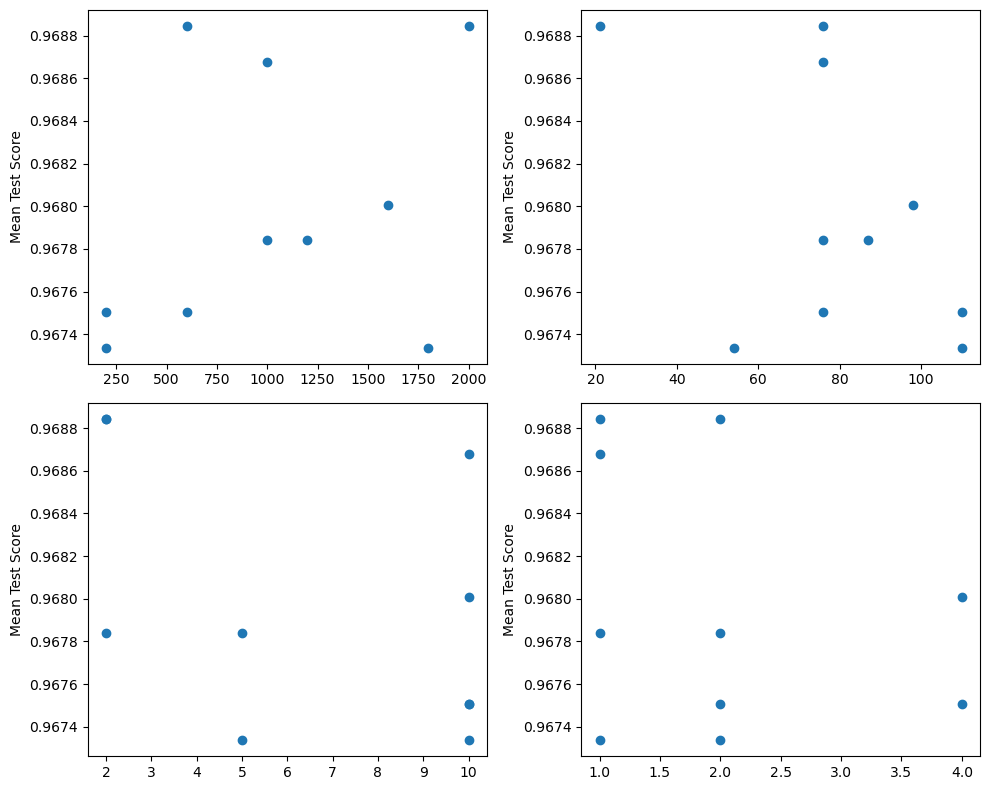

In [39]:
# Extract the mean test scores of the model for each parameter value
results = rf_random.cv_results_
n_estimators = results['param_n_estimators'].data
max_depth = results['param_max_depth'].data
min_samples_split = results['param_min_samples_split'].data
min_samples_leaf = results['param_min_samples_leaf'].data
max_features = results['param_max_features'].data
mean_test_score = results['mean_test_score']

# Plot the sensitivity of the model to each parameter
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = ax.flatten()
for i, param in enumerate([n_estimators, max_depth, min_samples_split, min_samples_leaf]):
    ax[i].scatter(param, mean_test_score)
    #ax[i].set_xlabel(param.name)
    ax[i].set_ylabel('Mean Test Score')
plt.tight_layout()
plt.show()

In [40]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 76,
 'bootstrap': False}

In [41]:
RF = RandomForestClassifier(**rf_random.best_params_)

In [43]:
RF.fit(X_train_G, y_train_G)

RandomForestClassifier(bootstrap=False, max_depth=76, min_samples_leaf=2,
                       n_estimators=600)

In [44]:
y_pred = RF.predict(X_val_G)

In [45]:
print(f"The f1-score on the validation set is {round(f1_score(y_val_G, y_pred),4)}")

The f1-score on the validation set is 0.5405


#### Mol2Vec

In [46]:
# SELECTION OF THE BEST PARAMETERS OF THE RANDOM FOREST 
start = time.time()

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_m, y_m)

end = time.time()

print(f"Runing time : {round(end-start)} s")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Runing time : 137 s


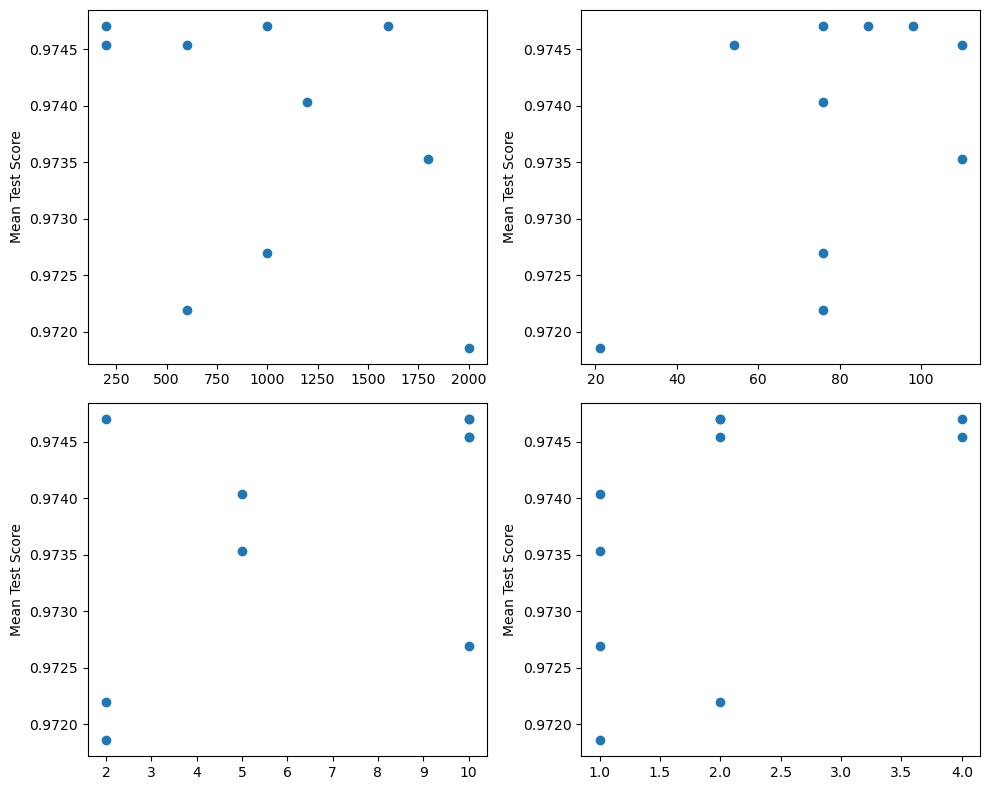

In [47]:
# Extract the mean test scores of the model for each parameter value
results = rf_random.cv_results_
n_estimators = results['param_n_estimators'].data
max_depth = results['param_max_depth'].data
min_samples_split = results['param_min_samples_split'].data
min_samples_leaf = results['param_min_samples_leaf'].data
max_features = results['param_max_features'].data
mean_test_score = results['mean_test_score']

# Plot the sensitivity of the model to each parameter
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = ax.flatten()
for i, param in enumerate([n_estimators, max_depth, min_samples_split, min_samples_leaf]):
    ax[i].scatter(param, mean_test_score)
    #ax[i].set_xlabel(param.name)
    ax[i].set_ylabel('Mean Test Score')
plt.tight_layout()
plt.show()

In [33]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [48]:
RF = RandomForestClassifier(**rf_random.best_params_)

In [49]:
RF.fit(X_train_m, y_train_m)

RandomForestClassifier(bootstrap=False, max_depth=98, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1600)

In [50]:
y_pred_m = RF.predict(X_val_m)

In [51]:
print(f"The f1-score on the validation set is {round(f1_score(y_val_m, y_pred_m),4)}")

The f1-score on the validation set is 0.7


### All dataframes concatenated

#### With PCA

In [71]:
# SELECTION OF THE BEST PARAMETERS OF THE RANDOM FOREST 
start = time.time()

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_all, y_train_all)

end = time.time()

print(f"Runing time : {round(end-start)} s")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Runing time : 447 s
[CV] END bootstrap=False, max_depth=98, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 2.8min
[CV] END bootstrap=False, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.9min
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  51.5s
[CV] END bootstrap=False, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.2min
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.7min
[CV] END bootstrap=True, max_depth=76, max_features=auto, min_samples_leaf=1, min_samples

In [72]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 76,
 'bootstrap': False}

[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=True, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  13.0s
[CV] END bootstrap=True, max_depth=76, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time= 1.4min
[CV] END bootstrap=False, max_depth=21, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.8min
[CV] END bootstrap=False, max_depth=98, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 2.4min
[CV] END bootstrap=False, max_depth=76, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  57.2s
[CV] END bootstrap=False, max_depth=21, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.9min
[CV] END bootstrap=False, max_depth

In [73]:
RF = RandomForestClassifier(n_estimators=600, min_samples_split=2, 
                            min_samples_leaf=2,max_features='auto',
                            max_depth=76, bootstrap=False)

In [74]:
RF.fit(X_train_all, y_train_all)

RandomForestClassifier(bootstrap=False, max_depth=76, min_samples_leaf=2,
                       n_estimators=600)

In [75]:
y_pred = RF.predict(X_val_all)

In [76]:
print(f"The f1-score on the validation set is {round(f1_score(y_val_all, y_pred),4)}")

The f1-score on the validation set is 0.7059


Overall Random Forest are as good as the SVM, even though it takes much more time to train and to fine-tune its hyperparameters.

## Gradient Boosting Descision Tree

In [52]:
# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [2, 3, 4],
    "subsample": [0.5, 0.8, 1],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

### Concatenated dataframes 

In [ ]:
# Define the model
model = GradientBoostingClassifier()

# Use GridSearchCV to tune the hyperparameters
grid_search = RandomizedSearchCV(model, param_grid, cv=5)
grid_search.fit(X_all, y_all)

# Print the best parameters and the corresponding accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

In [ ]:
# Use the best parameters to fit the final model and make predictions
best_model = GradientBoostingClassifier(**grid_search.best_params_)
best_model.fit(X_train_m, y_train_m)
y_pred = best_model.predict(X_val_m)
print(f"The f1-score on the validation set is {round(f1_score(y_val_m, y_pred_m),4)}")

We tried the Gradient Boosting algorithm, but it was taking too much time for the hyperparameters fine-tuning 

# Evaluation on the test set 

## Naive Bayesian 

In [72]:
%%time 

baseline_model = GaussianNB()

baseline_model.fit(X_all, y_all)

CPU times: user 8.21 ms, sys: 4.23 ms, total: 12.4 ms
Wall time: 10.5 ms


GaussianNB()

In [73]:
y_pred = baseline_model.predict(X_test_all)
print(f"The f1-score on the validation set is {round(f1_score(y_test_all, y_pred),4)}")

The f1-score on the validation set is 0.6496


## SVM

In [66]:
# Preprocess data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_all)
X_test = scaler.transform(X_test_all)

# Create SVM model with a linear kernel and default hyperparameters
svm_model = SVC(kernel='linear')

# Train SVM model on training data
svm_model.fit(X_train, y_all)

# Test SVM model on testing data
y_pred = svm_model.predict(X_test)

In [67]:
print(f"The f1-score on the validation set is {round(f1_score(y_test_all, y_pred),4)}")

The f1-score on the validation set is 0.6667


## Random Forest

In [36]:
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_all, y_all)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  55.2s
[CV] END bootstrap=True, max_depth=54, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.3s
[CV] END bootstrap=True, max_depth=54, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.4s
[CV] END bootstrap=True, max_depth=87, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  33.0s
[CV] END bootstrap=True, max_depth=76, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  40.2s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  32.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 1.1min
[CV] END bootstrap=False, max_depth=

In [37]:
RF = RandomForestClassifier(**rf_random.best_params_)

In [38]:
RF.fit(X_all, y_all)

RandomForestClassifier(bootstrap=False, max_depth=76, max_features='sqrt',
                       min_samples_split=10, n_estimators=1000)

In [39]:
y_pred = RF.predict(X_test_all)
print(f"The f1-score on the validation set is {round(f1_score(y_test_all, y_pred),4)}")

The f1-score on the validation set is 0.6374
